In [ ]:
import os, cv2, shutil, random
import json
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
from skimage import io
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline
from urllib.error import HTTPError

In [ ]:
from requests.compat import urlparse, urlunparse, urljoin
from bs4 import BeautifulSoup
import re
import requests
from requests import Session, request, get
import urllib.request
from urllib.request import urlopen
from urllib.error import URLError, HTTPError
import os
import pandas as pd
import numpy as np
from functools import reduce 
import sqlite3
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path

from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout, Input
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import resnet, resnet_v2, ResNet50, ResNet50V2, EfficientNetB3, InceptionV3, InceptionResNetV2

In [ ]:
# def myPreprocess_image(image_url):
#     try:
#         image_res = requests.get(image_url)

#         base_directory = "/content/drive/MyDrive/Test_for_Siam/test_002013"
#         os.chdir(base_directory)
#         with open("/content/drive/MyDrive/Test_for_Siam/test_002013/{}.{}".format(
#             image_url.split('/')[-2],image_url[-3:]),"wb") as f:
#             f.write(image_res.content)

    
#         image_string = tf.io.read_file(f.name)
#         try:
#             image = tf.image.decode_jpeg(image_string, channels=3)
#             image = tf.image.convert_image_dtype(image, tf.float32)
#             image = tf.image.resize(image, TARGET_SHAPE[:2]) # TARGET_SHAPE
#             return image
#         except:
#             pass
#     except:
#         pass

In [ ]:
def download_image(dataframe):
    anchor_list = dataframe.anchor.to_list()
    positive_list = dataframe.positive.to_list()
    
    for i in anchor_list:
        image_res = requests.get(i)
        with open("/content/drive/MyDrive/Test_for_Siam/test_002013/{}_{}.{}".format(
                i.split('/')[-2],i.split('/')[-1][:-4],i[-3:]),"wb") as f: 
            f.write(image_res.content)

    for i in positive_list:
        image_res = requests.get(i)
        with open("/content/drive/MyDrive/Test_for_Siam/test_002013/{}_{}.{}".format(
                i.split('/')[-2],i.split('/')[-1][:-4],i[-3:]),"wb") as f: 
            f.write(image_res.content)

In [ ]:
def myPreprocess_image_fin(fname):
    image_string = tf.io.read_file(fname)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (224,224,3)[:2]) # TARGET_SHAPE
    return image

In [ ]:
def substitute(url):
    base_dir = r"/content/drive/Othercomputers/내 노트북 (2)/test_002013"
    for i in os.listdir(base_dir):
        if i == (url.split('/')[-2] + '_' + url.split('/')[-1][:-4] + '.' + url[-3:]):
            try:
                if tf.io.read_file(os.path.join(base_dir ,i)):
                    return os.path.join(base_dir ,i)
            except:
                return "0"
    return "0"

In [ ]:
def create_negative(dataframe, idx): 
    rand_int = random.randint(0, len(dataframe)-1)
    if dataframe.loc[idx]["goodsId"] != dataframe.loc[rand_int]["goodsId"]:
        dataframe.loc[idx]["negative"] = dataframe.loc[rand_int]["positive"]
        
    else:
        create_negative(dataframe, idx)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
len(os.listdir("/content/drive/Othercomputers/내 노트북 (2)/test_002013"))

1667

In [ ]:
# image_url = "https://image.msscdn.net/images/goods_img/20200922/1616798/1616798_4_500.jpg"
# image_res = requests.get(image_url)

# base_directory = "/content/drive/MyDrive/Test_for_Siam/test_002013"
# os.chdir(base_directory)
# with open("/content/drive/MyDrive/Test_for_Siam/test_002013/{}.{}".format(
#     image_url.split('/')[-2],image_url[-3:]),"wb") as f:
#     f.write(image_res.content)

# image_string = tf.io.read_file(f.name)

In [ ]:
# def preprocess_image(filename):
#     """
#     Load the specified file as a JPEG image, preprocess it and
#     resize it to the target shape.
#     """
#     try:
#       data_dir = tf.keras.utils.get_file(origin=filename)
#       image_string = tf.io.read_file(data_dir)
#       image = tf.image.decode_jpeg(image_string, channels=3)
#       image = tf.image.convert_image_dtype(image, tf.float32)
#       image = tf.image.resize(image, TARGET_SHAPE[:2])
#       return image
#     elif HTTP error:
#       preprocess_image(filename)

def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images,
    preprocess them.
    """
    return preprocess_image(anchor), preprocess_image(positive), preprocess_image(negative)

def visualize(anchor, positive, negative, n=3):
    """Visualize triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(3*n, 9))

    axs = fig.subplots(n, 3)
    for i in range(n):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])

Training

In [ ]:
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
TARGET_SHAPE = (224, 224, 3)
EMBEDDING_DIMENSION = 256
EPOCHS = 100

In [ ]:
tf.keras.backend.clear_session()

base_model = ResNet50(weights="imagenet", input_shape=TARGET_SHAPE, include_top=False)

for layer in base_model.layers:
    layer.trainable = True

x = Flatten()(base_model.output)
x = Dense(512, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)

output = Dense(EMBEDDING_DIMENSION, activation="linear")(x)

embedding = Model(base_model.input, output, name="Embedding")

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
class DistanceLayer(tf.keras.layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

anchor_input = Input(name="anchor", shape=TARGET_SHAPE)
positive_input = Input(name="positive", shape=TARGET_SHAPE)
negative_input = Input(name="negative", shape=TARGET_SHAPE)

distances = DistanceLayer()(embedding(resnet.preprocess_input(anchor_input)), embedding(resnet.preprocess_input(positive_input)), embedding(resnet.preprocess_input(negative_input)))

siamese_network = Model(inputs=[anchor_input, positive_input, negative_input], outputs=distances)

In [ ]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_network(data)
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        return [self.loss_tracker]

Load Data

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
df_002013 = pd.read_csv("/content/drive/MyDrive/Test_for_Siam/photoReview_002_002013.csv", dtype=object)
list_002013_a = df_002013["goods_image"].to_list()
list_002013_p = df_002013["reviewImageUrlPhoto"].to_list()
list_002013_g = df_002013["goodsId"].to_list()
df_002013_apn = pd.DataFrame(columns = ["anchor", "positive", "negative", "goodsId"])
df_002013_apn["anchor"] = list_002013_a
df_002013_apn["positive"] = list_002013_p
df_002013_apn["goodsId"] = list_002013_g
df_002013_apn

,anchor,positive,negative,goodsId
0,https://image.msscdn.net/images/goods_img/2020...,https://image.msscdn.net/data/estimate/1616798...,NaN,1616798
1,https://image.msscdn.net/images/goods_img/2020...,https://image.msscdn.net/data/estimate/1616798...,NaN,1616798
2,https://image.msscdn.net/images/goods_img/2020...,https://image.msscdn.net/data/estimate/1616798...,NaN,1616798
3,https://image.msscdn.net/images/goods_img/2020...,https://image.msscdn.net/data/estimate/1616798...,NaN,1616798
4,https://image.msscdn.net/images/goods_img/2020...,https://image.msscdn.net/data/estimate/1616798...,NaN,1616798
...,...,...,...,...
1324,https://image.msscdn.net/images/goods_img/2022...,https://image.msscdn.net/data/estimate/2685523...,NaN,2685523
1325,https://image.msscdn.net/images/goods_img/2022...,https://image.msscdn.net/data/estimate/2640937...,NaN,2640937
1326,https://image.msscdn.net/images/goods_img/2021...,https://image.msscdn.net/data/estimate/2183578...,NaN,2183578
1327,https://image.msscdn.net/images/goods_img/2021...,https://image.msscdn.net/data/estimate/2147114...,NaN,2147114


In [ ]:
sub_anchor = list()
for j in df_002013_apn["anchor"]:
    k = substitute(j)
    sub_anchor.append(k)

In [ ]:
sub_anchor.index("0")

ValueError: ignored

In [ ]:
sub_positive = list()
for j in df_002013_apn["positive"]:
    k = substitute(j)
    sub_positive.append(k)

In [ ]:
sub_positive.index("0")

ValueError: ignored

In [ ]:
for i in range(len(df_002013_apn)):
    create_negative(df_002013_apn, i)

In [ ]:
df_002013_apn

,anchor,positive,negative,goodsId
0,https://image.msscdn.net/images/goods_img/2020...,https://image.msscdn.net/data/estimate/1616798...,https://image.msscdn.net/data/estimate/2196467...,1616798
1,https://image.msscdn.net/images/goods_img/2020...,https://image.msscdn.net/data/estimate/1616798...,https://image.msscdn.net/data/estimate/2282452...,1616798
2,https://image.msscdn.net/images/goods_img/2020...,https://image.msscdn.net/data/estimate/1616798...,https://image.msscdn.net/data/estimate/2834587...,1616798
3,https://image.msscdn.net/images/goods_img/2020...,https://image.msscdn.net/data/estimate/1616798...,https://image.msscdn.net/data/estimate/2744500...,1616798
4,https://image.msscdn.net/images/goods_img/2020...,https://image.msscdn.net/data/estimate/1616798...,https://image.msscdn.net/data/estimate/2871132...,1616798
...,...,...,...,...
1324,https://image.msscdn.net/images/goods_img/2022...,https://image.msscdn.net/data/estimate/2685523...,https://image.msscdn.net/data/estimate/1643839...,2685523
1325,https://image.msscdn.net/images/goods_img/2022...,https://image.msscdn.net/data/estimate/2640937...,https://image.msscdn.net/data/estimate/2718030...,2640937
1326,https://image.msscdn.net/images/goods_img/2021...,https://image.msscdn.net/data/estimate/2183578...,https://image.msscdn.net/data/estimate/2193063...,2183578
1327,https://image.msscdn.net/images/goods_img/2021...,https://image.msscdn.net/data/estimate/2147114...,https://image.msscdn.net/data/estimate/2193063...,2147114


In [ ]:
sub_negative = list()
for j in df_002013_apn["negative"]:
    k = substitute(j)
    sub_negative.append(k)

In [ ]:
sub_negative.index("0")

ValueError: ignored

In [ ]:
TARGET_SHAPE = (224,224,3)
anchor_tensor = list()
for i in sub_anchor:
    k = myPreprocess_image_fin(i)
    anchor_tensor.append(k)

positive_tensor = list()
for i in sub_positive:
    k = myPreprocess_image_fin(i)
    positive_tensor.append(k)
    
negative_tensor = list()    
for i in sub_negative:
    k = myPreprocess_image_fin(i)
    negative_tensor.append(k)

In [ ]:
image_count = len(anchor_tensor)

In [ ]:
print(len(positive_tensor))

1329


In [ ]:
print(image_count)

1329


In [ ]:
anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_tensor)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_tensor)
negative_dataset = tf.data.Dataset.from_tensor_slices(negative_tensor)

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
# dataset = dataset.map(preprocess_triplets)

train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

In [ ]:
print(len(train_dataset), len(val_dataset))

34 9


In [ ]:
dataset

<ShuffleDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None))>

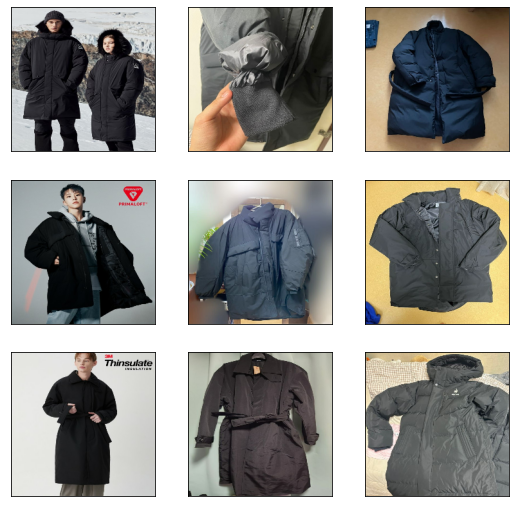

In [ ]:
visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)]

In [ ]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_RATE), metrics = ['accuracy'])
siamese_model.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset, callbacks=callbacks)

Epoch 1/100
34/34 [==============================] - ETA: 0s - loss: 0.5090

34/34 [==============================] - 35s 349ms/step - loss: 0.5090 - val_loss: 0.4684
Epoch 2/100
34/34 [==============================] - ETA: 0s - loss: 0.4499

34/34 [==============================] - 7s 218ms/step - loss: 0.4499 - val_loss: 0.4041
Epoch 3/100
34/34 [==============================] - ETA: 0s - loss: 0.4120

34/34 [==============================] - 7s 212ms/step - loss: 0.4120 - val_loss: 0.4159
Epoch 4/100
34/34 [==============================] - ETA: 0s - loss: 0.4358

34/34 [==============================] - 7s 212ms/step - loss: 0.4358 - val_loss: 0.4443
Epoch 5/100
34/34 [==============================] - ETA: 0s - loss: 0.4121

34/34 [==============================] - 7s 211ms/step - loss: 0.4121 - val_loss: 0.5315
Epoch 6/100
34/34 [==============================] - ETA: 0s - loss: 0.4366

34/34 [==============================] - 7s 212ms/step - loss: 0.4366 - val_loss: 0.5276
Epoch 7/100
34/34 [==============================] - ETA: 0s - loss: 0.6500

34/34 [==============================] - 7s 212ms/step - loss: 0.6500 - val_loss: 0.5976
Epoch 8/100
34/34 [==============================] - ETA: 0s - loss: 0.6389

34/34 [==============================] - 7s 211ms/step - loss: 0.6389 - val_loss: 0.4560
Epoch 9/100
34/34 [==============================] - ETA: 0s - loss: 0.4511

34/34 [==============================] - 7s 212ms/step - loss: 0.4511 - val_loss: 0.5138
Epoch 10/100
34/34 [==============================] - ETA: 0s - loss: 0.4197

34/34 [==============================] - 7s 219ms/step - loss: 0.4197 - val_loss: 0.4014
Epoch 11/100
34/34 [==============================] - ETA: 0s - loss: 0.3957

34/34 [==============================] - 7s 212ms/step - loss: 0.3957 - val_loss: 0.4862
Epoch 12/100
34/34 [==============================] - ETA: 0s - loss: 0.4539

34/34 [==============================] - 7s 212ms/step - loss: 0.4539 - val_loss: 0.4726
Epoch 13/100
34/34 [==============================] - ETA: 0s - loss: 0.4281

34/34 [==============================] - 7s 212ms/step - loss: 0.4281 - val_loss: 0.4709
Epoch 14/100
34/34 [==============================] - ETA: 0s - loss: 0.4804

34/34 [==============================] - 7s 211ms/step - loss: 0.4804 - val_loss: 0.4404
Epoch 15/100
34/34 [==============================] - ETA: 0s - loss: 0.4632

34/34 [==============================] - 7s 212ms/step - loss: 0.4632 - val_loss: 0.5440
Epoch 16/100
34/34 [==============================] - ETA: 0s - loss: 0.5072

34/34 [==============================] - 7s 212ms/step - loss: 0.5072 - val_loss: 0.4630
Epoch 17/100
34/34 [==============================] - ETA: 0s - loss: 0.4724

34/34 [==============================] - 7s 212ms/step - loss: 0.4724 - val_loss: 0.4301
Epoch 18/100
34/34 [==============================] - ETA: 0s - loss: 0.5597

34/34 [==============================] - 7s 212ms/step - loss: 0.5597 - val_loss: 0.4358
Epoch 19/100
34/34 [==============================] - ETA: 0s - loss: 0.5737

34/34 [==============================] - 7s 212ms/step - loss: 0.5737 - val_loss: 0.4502
Epoch 20/100
34/34 [==============================] - ETA: 0s - loss: 0.4376

34/34 [==============================] - 7s 216ms/step - loss: 0.4376 - val_loss: 0.4510


In [ ]:
siamese_model.compile()

In [ ]:
sample = next(iter(train_dataset))
anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (embedding(resnet.preprocess_input(anchor)), embedding(resnet.preprocess_input(positive)), embedding(resnet.preprocess_input(negative)),)

In [ ]:
anchors, positives, negatives = sample
for i in range(len(anchor_embedding)):
    anchor, positive, negative = anchors[i], positives[i], negatives[i]
    positive_distance = np.linalg.norm(anchor_embedding[i] - positive_embedding[i], ord=2)*1e4
    negative_distance = np.linalg.norm(anchor_embedding[i] - negative_embedding[i], ord=2)*1e4
    positive_distance, negative_distance = round(positive_distance)/1e4, round(negative_distance)/1e4
    plt.figure(figsize=(16,9))
    plt.subplot(131)
    plt.imshow(anchor)
    plt.axis("off")
    plt.title("Anchor")
    plt.subplot(132)
    plt.imshow(positive)
    plt.axis("off")
    plt.title(f"Anchor to Positive Distance: {positive_distance}")
    plt.subplot(133)
    plt.imshow(negative)
    plt.axis("off")
    plt.title(f"Anchor to Negative Distance: {negative_distance}")
    plt.show()        

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
embedding.save("002013.h5")

In [ ]:
!cp 002013.h5 /content/drive/MyDrive/Test_for_Siam

In [ ]:
TARGET_SHAPE = (224,224,3)
def preprocess_image(filename: str):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    
    Args:
        filename: Absolute / Relative file path for the image
    
    Returns:
        Preprocessed inputs of type tensorflow.Tensor for Embedding Generation 
    """
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, TARGET_SHAPE[:2])
    image = resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0)


def generate_embedding(dataframe, embedding_generator):
    """
    Use the specified dataframe and Embeddings model to 
    calculate embeddings for all records in the dataframe
    
    Args:
        dataframe: Dataframe to get records for Embedding Generation
        embedding_genrator: Tensorflow Model to generate embeddings
    
    Returns:
        Dataframe with embeddings for each record.
    """
    embeddings_review = list()
    for i, row in tqdm(dataframe.iterrows(), total=dataframe.shape[0]):
        filename = row["image_path_review"]
        image = preprocess_image(filename)
        embedding = embedding_generator(image)
        embeddings_review.append(embedding[0].numpy().astype(np.float32).tolist())
    dataframe["embedding_review"] = embeddings_review
    embeddings_sample = list()
    for i, row in tqdm(dataframe.iterrows(), total=dataframe.shape[0]):
        filename = row["image_path_sample"]
        image = preprocess_image(filename)
        embedding = embedding_generator(image)
        embeddings_sample.append(embedding[0].numpy().astype(np.float32).tolist())
    dataframe["embedding_sample"] = embeddings_sample
    return dataframe

In [ ]:
c002013_embedding = load_model("/content/drive/MyDrive/Test_for_Siam/002013.h5", compile=False)

In [ ]:
df_002013_photo = pd.read_csv("/content/drive/MyDrive/Test_for_Siam/photoReview_002_002013.csv", dtype=object)

In [ ]:
df_002013_photo

,goodsId,reviewIdPhoto,reviewDatePhoto,reviewImageUrlPhoto,major_category,mid_category,goods_image
0,1616798,23010380,2021.12.06,https://image.msscdn.net/data/estimate/1616798...,002,002013,https://image.msscdn.net/images/goods_img/2020...
1,1616798,30204771,2022.07.09,https://image.msscdn.net/data/estimate/1616798...,002,002013,https://image.msscdn.net/images/goods_img/2020...
2,1616798,35704635,며칠전으로 표시된 리뷰,https://image.msscdn.net/data/estimate/1616798...,002,002013,https://image.msscdn.net/images/goods_img/2020...
3,1616798,36089494,며칠전으로 표시된 리뷰,https://image.msscdn.net/data/estimate/1616798...,002,002013,https://image.msscdn.net/images/goods_img/2020...
4,1616798,36110715,며칠전으로 표시된 리뷰,https://image.msscdn.net/data/estimate/1616798...,002,002013,https://image.msscdn.net/images/goods_img/2020...
...,...,...,...,...,...,...,...
1324,2685523,36553920,며칠전으로 표시된 리뷰,https://image.msscdn.net/data/estimate/2685523...,002,002013,https://image.msscdn.net/images/goods_img/2022...
1325,2640937,32978580,2022.09.30,https://image.msscdn.net/data/estimate/2640937...,002,002013,https://image.msscdn.net/images/goods_img/2022...
1326,2183578,33594127,2022.10.14,https://image.msscdn.net/data/estimate/2183578...,002,002013,https://image.msscdn.net/images/goods_img/2021...
1327,2147114,36461816,며칠전으로 표시된 리뷰,https://image.msscdn.net/data/estimate/2147114...,002,002013,https://image.msscdn.net/images/goods_img/2021...


In [ ]:
df_002013_photo["image_path_review"] = sub_positive
df_002013_photo["image_path_sample"] = sub_anchor
df_002013_photo

,goodsId,reviewIdPhoto,reviewDatePhoto,reviewImageUrlPhoto,major_category,mid_category,goods_image,image_path,image_path_review,image_path_sample
0,1616798,23010380,2021.12.06,https://image.msscdn.net/data/estimate/1616798...,002,002013,https://image.msscdn.net/images/goods_img/2020...,/content/drive/Othercomputers/내 노트북 (2)/t...,/content/drive/Othercomputers/내 노트북 (2)/t...,/content/drive/Othercomputers/내 노트북 (2)/t...
1,1616798,30204771,2022.07.09,https://image.msscdn.net/data/estimate/1616798...,002,002013,https://image.msscdn.net/images/goods_img/2020...,/content/drive/Othercomputers/내 노트북 (2)/t...,/content/drive/Othercomputers/내 노트북 (2)/t...,/content/drive/Othercomputers/내 노트북 (2)/t...
2,1616798,35704635,며칠전으로 표시된 리뷰,https://image.msscdn.net/data/estimate/1616798...,002,002013,https://image.msscdn.net/images/goods_img/2020...,/content/drive/Othercomputers/내 노트북 (2)/t...,/content/drive/Othercomputers/내 노트북 (2)/t...,/content/drive/Othercomputers/내 노트북 (2)/t...
3,1616798,36089494,며칠전으로 표시된 리뷰,https://image.msscdn.net/data/estimate/1616798...,002,002013,https://image.msscdn.net/images/goods_img/2020...,/content/drive/Othercomputers/내 노트북 (2)/t...,/content/drive/Othercomputers/내 노트북 (2)/t...,/content/drive/Othercomputers/내 노트북 (2)/t...
4,1616798,36110715,며칠전으로 표시된 리뷰,https://image.msscdn.net/data/estimate/1616798...,002,002013,https://image.msscdn.net/images/goods_img/2020...,/content/drive/Othercomputers/내 노트북 (2)/t...,/content/drive/Othercomputers/내 노트북 (2)/t...,/content/drive/Othercomputers/내 노트북 (2)/t...
...,...,...,...,...,...,...,...,...,...,...
1324,2685523,36553920,며칠전으로 표시된 리뷰,https://image.msscdn.net/data/estimate/2685523...,002,002013,https://image.msscdn.net/images/goods_img/2022...,/content/drive/Othercomputers/내 노트북 (2)/t...,/content/drive/Othercomputers/내 노트북 (2)/t...,/content/drive/Othercomputers/내 노트북 (2)/t...
1325,2640937,32978580,2022.09.30,https://image.msscdn.net/data/estimate/2640937...,002,002013,https://image.msscdn.net/images/goods_img/2022...,/content/drive/Othercomputers/내 노트북 (2)/t...,/content/drive/Othercomputers/내 노트북 (2)/t...,/content/drive/Othercomputers/내 노트북 (2)/t...
1326,2183578,33594127,2022.10.14,https://image.msscdn.net/data/estimate/2183578...,002,002013,https://image.msscdn.net/images/goods_img/2021...,/content/drive/Othercomputers/내 노트북 (2)/t...,/content/drive/Othercomputers/내 노트북 (2)/t...,/content/drive/Othercomputers/내 노트북 (2)/t...
1327,2147114,36461816,며칠전으로 표시된 리뷰,https://image.msscdn.net/data/estimate/2147114...,002,002013,https://image.msscdn.net/images/goods_img/2021...,/content/drive/Othercomputers/내 노트북 (2)/t...,/content/drive/Othercomputers/내 노트북 (2)/t...,/content/drive/Othercomputers/내 노트북 (2)/t...


In [ ]:
sim_002013 = generate_embedding(df_002013_photo, c002013_embedding)
sim_002013.to_csv("/content/drive/MyDrive/Test_for_Siam.sim_002013.csv", index=False)
df_sim_002013 = pd.read_csv("/content/drive/MyDrive/Test_for_Siam.sim_002013.csv", dtype=object)

100%|██████████| 1329/1329 [01:37<00:00, 13.70it/s]


In [ ]:
df_sim_002013

,goodsId,reviewIdPhoto,reviewDatePhoto,reviewImageUrlPhoto,major_category,mid_category,goods_image,image_path,image_path_review,image_path_sample,embedding_review,embedding_sample
0,1616798,23010380,2021.12.06,https://image.msscdn.net/data/estimate/1616798...,002,002013,https://image.msscdn.net/images/goods_img/2020...,/content/drive/Othercomputers/내 노트북 (2)/t...,/content/drive/Othercomputers/내 노트북 (2)/t...,/content/drive/Othercomputers/내 노트북 (2)/t...,"[4.797895431518555, 47.537811279296875, 28.422...","[4.779669761657715, 47.515010833740234, 28.434..."
1,1616798,30204771,2022.07.09,https://image.msscdn.net/data/estimate/1616798...,002,002013,https://image.msscdn.net/images/goods_img/2020...,/content/drive/Othercomputers/내 노트북 (2)/t...,/content/drive/Othercomputers/내 노트북 (2)/t...,/content/drive/Othercomputers/내 노트북 (2)/t...,"[4.7870988845825195, 47.45939636230469, 28.402...","[4.779669761657715, 47.515010833740234, 28.434..."
2,1616798,35704635,며칠전으로 표시된 리뷰,https://image.msscdn.net/data/estimate/1616798...,002,002013,https://image.msscdn.net/images/goods_img/2020...,/content/drive/Othercomputers/내 노트북 (2)/t...,/content/drive/Othercomputers/내 노트북 (2)/t...,/content/drive/Othercomputers/내 노트북 (2)/t...,"[4.787035942077637, 47.52483367919922, 28.4246...","[4.779669761657715, 47.515010833740234, 28.434..."
3,1616798,36089494,며칠전으로 표시된 리뷰,https://image.msscdn.net/data/estimate/1616798...,002,002013,https://image.msscdn.net/images/goods_img/2020...,/content/drive/Othercomputers/내 노트북 (2)/t...,/content/drive/Othercomputers/내 노트북 (2)/t...,/content/drive/Othercomputers/내 노트북 (2)/t...,"[4.787961006164551, 47.49927520751953, 28.4430...","[4.779669761657715, 47.515010833740234, 28.434..."
4,1616798,36110715,며칠전으로 표시된 리뷰,https://image.msscdn.net/data/estimate/1616798...,002,002013,https://image.msscdn.net/images/goods_img/2020...,/content/drive/Othercomputers/내 노트북 (2)/t...,/content/drive/Othercomputers/내 노트북 (2)/t...,/content/drive/Othercomputers/내 노트북 (2)/t...,"[4.772589683532715, 47.46470642089844, 28.4191...","[4.779669761657715, 47.515010833740234, 28.434..."
...,...,...,...,...,...,...,...,...,...,...,...,...
1324,2685523,36553920,며칠전으로 표시된 리뷰,https://image.msscdn.net/data/estimate/2685523...,002,002013,https://image.msscdn.net/images/goods_img/2022...,/content/drive/Othercomputers/내 노트북 (2)/t...,/content/drive/Othercomputers/내 노트북 (2)/t...,/content/drive/Othercomputers/내 노트북 (2)/t...,"[4.811640739440918, 47.46338653564453, 28.4226...","[4.776240348815918, 47.434425354003906, 28.411..."
1325,2640937,32978580,2022.09.30,https://image.msscdn.net/data/estimate/2640937...,002,002013,https://image.msscdn.net/images/goods_img/2022...,/content/drive/Othercomputers/내 노트북 (2)/t...,/content/drive/Othercomputers/내 노트북 (2)/t...,/content/drive/Othercomputers/내 노트북 (2)/t...,"[4.772486686706543, 47.51301956176758, 28.4325...","[4.800378799438477, 47.53586959838867, 28.4314..."
1326,2183578,33594127,2022.10.14,https://image.msscdn.net/data/estimate/2183578...,002,002013,https://image.msscdn.net/images/goods_img/2021...,/content/drive/Othercomputers/내 노트북 (2)/t...,/content/drive/Othercomputers/내 노트북 (2)/t...,/content/drive/Othercomputers/내 노트북 (2)/t...,"[4.790809631347656, 47.47194290161133, 28.4191...","[4.739589691162109, 47.49814987182617, 28.3895..."
1327,2147114,36461816,며칠전으로 표시된 리뷰,https://image.msscdn.net/data/estimate/2147114...,002,002013,https://image.msscdn.net/images/goods_img/2021...,/content/drive/Othercomputers/내 노트북 (2)/t...,/content/drive/Othercomputers/내 노트북 (2)/t...,/content/drive/Othercomputers/내 노트북 (2)/t...,"[4.7934160232543945, 47.46125411987305, 28.430...","[4.747678756713867, 47.503604888916016, 28.390..."


In [ ]:
tqdm.pandas()
query_embedding = df_sim_002013.iloc[random.randint(0,df_sim_002013.shape[0])].embedding_sample
df_sim_002013['distance_sample'] = df_sim_002013['embedding_sample'].progress_apply(lambda x: np.linalg.norm(np.asarray(eval(x), dtype=np.float32) - np.asarray(eval(query_embedding), dtype=np.float32)))
df_sim_002013 = df_sim_002013.sort_values(by='distance_sample').reset_index(drop=True)
plt.figure(figsize=(16,9))
plt.imshow(io.imread(df_sim_002013.iloc[0].image_path_review))
plt.title("Query Image")
plt.axis("off");plt.show()
print(254*"=")
print(254*"=")
for i, row in df_sim_002013.iloc[1:21].iterrows():
    plt.figure(figsize=(16,9))
    image = io.imread(row["image_path_sample"])
    plt.imshow(image);plt.axis("off")
    plt.show()
    # print("Shop Now @ ", row["product_url"])
    print(254*"=")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
tqdm.pandas()
query_embedding = df_sim_002013.iloc[random.randint(0,df_sim_002013.shape[0])].embedding_review
df_sim_002013['distance_review'] = df_sim_002013['embedding_review'].progress_apply(lambda x: np.linalg.norm(np.asarray(eval(x), dtype=np.float32) - np.asarray(eval(query_embedding), dtype=np.float32)))
df_sim_002013 = df_sim_002013.sort_values(by='distance_review').reset_index(drop=True)
plt.figure(figsize=(16,9))
plt.imshow(io.imread(df_sim_002013.iloc[0].image_path_review))
plt.title("Query Image")
plt.axis("off");plt.show()
print(254*"=")
print(254*"=")
for i, row in df_sim_002013.iloc[1:21].iterrows():
    plt.figure(figsize=(16,9))
    image = io.imread(row["image_path_review"])
    plt.imshow(image);plt.axis("off")
    plt.show()
    # print("Shop Now @ ", row["product_url"])
    print(254*"=")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
tqdm.pandas()
query = "/content/drive/MyDrive/Test_for_Siam/queryimg2685520.jpg"
query_image = preprocess_image(query)
query_embedding_ = c002013_embedding(query_image)[0].numpy().astype(np.float32).tolist()
query_embedding_ = str(query_embedding_)
df_sim_002013['distance_review'] = df_sim_002013['embedding_review'].progress_apply(lambda x: np.linalg.norm(np.asarray(eval(x), dtype=np.float32) - np.asarray(eval(query_embedding_), dtype=np.float32)))
df_sim_002013 = df_sim_002013.sort_values(by='distance_review').reset_index(drop=True)
plt.figure(figsize=(16,9))
plt.imshow(io.imread(query))
plt.title("Query Image")
plt.axis("off");plt.show()
print(254*"=")
print(254*"=")
for i, row in df_sim_002013.iloc[1:21].iterrows():
    plt.figure(figsize=(16,9))
    image = io.imread(row["image_path_review"])
    plt.imshow(image);plt.axis("off")
    plt.show()
    # print("Shop Now @ ", row["product_url"])
    print(254*"=")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
len(df_sim_002013.reviewImageUrlPhoto)

1329

In [ ]:
len(set(df_sim_002013.reviewImageUrlPhoto))

1329

In [ ]:
len(set(df_sim_002013.image_path))

338